In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import regex as re
import string
import matplotlib as plt
import seaborn as sns

In [2]:
df_mov_nam = pd.read_csv('../data/imdb_names.csv')
# Data has been scraped from the publicly available website https://www.imdb.com.
# All the movies with more than 100 votes have been scraped as of 01/01/2020.

/home/guillermo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df_mov_nam

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,Le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,...,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,$ 3507171,NaN,NaN,4.0
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,...,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,NaN,$ 7299062,NaN,6.0,4.0
85852,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,...,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",NaN,7.9,265,NaN,NaN,NaN,NaN,NaN,NaN
85853,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,...,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",NaN,6.4,194,NaN,NaN,$ 2833,NaN,NaN,NaN


In [4]:
df_mov_nam.dtypes
# voting columns have different data types

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [5]:
df_mov_nam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64
 15  vo

In [6]:
df_mov_nam.isnull().sum()
# Do we actually need income columns? I am going to leave them for now
# We must no something about NaNs in the reviews columns and others like country, language, description

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     64
language                   833
director                    87
writer                    1572
production_company        4455
actors                      69
description               2115
avg_vote                     0
votes                        0
budget                   62145
usa_gross_income         70529
worlwide_gross_income    54839
metascore                72550
reviews_from_users        7597
reviews_from_critics     11797
dtype: int64

In [7]:
list(df_mov_nam["description"].sample())

['A story about a father and his kid , who are travelling around the world']

In [8]:
list(df_mov_nam['country'].sample(10))
# Movies can have more than one country of origin

['USA',
 'USA',
 'Sweden',
 'Denmark',
 'Japan',
 'USA',
 'Japan',
 'USA',
 'Germany',
 'USA']

In [9]:
print(df_mov_nam["date_published"].unique())
# Month and day are not important for the study so we are going to drop this column

['1894-10-09' '1906-12-26' '1911-08-19' ... '2020-10-22' '2019-01-13'
 '2020-09-04']


In [10]:
df_mov_nam = df_mov_nam.drop("date_published", axis=1)

In [11]:
df_mov_nam.head(2)

,imdb_title_id,title,original_title,year,genre,duration,country,language,director,writer,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0


In [12]:
type(df_mov_nam["year"].unique())

numpy.ndarray

In [13]:
def cleanstryear(x):
    '''
    This function clean my column year database from string characters
    '''
    if x == 'TV Movie 2019':
        return 2019
    else:
        return x

In [14]:
df_mov_nam.year=df_mov_nam.year.apply(cleanstryear)

In [15]:
# Tranform all values in year to INTS
df_mov_nam["year"] = df_mov_nam.year.astype(int)

In [16]:
df_mov_nam.year.unique()

array([1894, 1906, 1911, 1912, 1919, 1913, 1914, 1915, 1916, 1917, 1918,
       1920, 1921, 1924, 1922, 1923, 1925, 1926, 1935, 1927, 1928, 1983,
       1929, 1930, 1932, 1931, 1937, 1938, 1933, 1934, 1936, 1940, 1939,
       1942, 1943, 1941, 1948, 1944, 2001, 1946, 1945, 1947, 1973, 1949,
       1950, 1952, 1951, 1962, 1953, 1954, 1955, 1961, 1956, 1958, 1957,
       1959, 1960, 1963, 1965, 1971, 1964, 1966, 1968, 1967, 1969, 1976,
       1970, 1979, 1972, 1981, 1978, 2000, 1989, 1975, 1974, 1986, 1990,
       2018, 1977, 1982, 1980, 1993, 1984, 1985, 1988, 1987, 2005, 1991,
       2002, 1994, 1992, 1995, 2017, 1997, 1996, 2006, 1999, 1998, 2007,
       2008, 2003, 2004, 2010, 2009, 2011, 2013, 2012, 2016, 2015, 2014,
       2019, 2020])

"title" column is translated to italian if necessary, we are going to drop this column though we might create a new one later for translation.

In [17]:
# comparing title and original_title
df_mov_nam[['title','original_title']].sample(n=10)

,title,original_title
2364,The Dark Hour,The Dark Hour
44216,Ladies' Night,Ladies' Night
19243,La saggezza nel sangue,Wise Blood
7819,Un turco napoletano,Un turco napoletano
46414,Virgil,Virgil
34910,Passe montagne,Passe montagne
16890,L'assassino è costretto ad uccidere ancora,L'assassino è costretto ad uccidere ancora
66175,Big Bad Wolves,Big Bad Wolves
75619,The Last King,Birkebeinerne
76510,Soul to Keep,Soul to Keep


In [18]:
df_mov_nam = df_mov_nam.drop("title", axis=1)

In [19]:
df_mov_nam.head(3)
# My dataset is already sorted in ascendding order by year

,imdb_title_id,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,1911,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0


In [20]:
# Filling string NaNs with 0 in important columns like country, language, director, prod_comp, actors, description and writer which have a small number of NaNs to address
df_mov_nam.fillna({"language": 0,
                    "director": 0,
                    "country": 0,
                    "writer": 0,
                    "production_company": 0,
                    "actors": 0,
                    "description": 0})
df_mov_nam.head(2)

,imdb_title_id,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0


In [21]:
df_mov_nam = df_mov_nam.fillna({"language": 0,
                                "director": 0,
                                "country": 0,
                                "writer": 0,
                                "production_company": 0,
                                "actors": 0,
                                "description": 0})

In [22]:
df_mov_nam[["country", "language", "director", "writer", "production_company", "actors", "description"]].isnull().sum()

country               0
language              0
director              0
writer                0
production_company    0
actors                0
description           0
dtype: int64

Exploring voting/review numeric values

In [23]:
# We d not need budget and income columns for our analysis
df_mov_nam = df_mov_nam.drop(["budget", "usa_gross_income", "worlwide_gross_income"], axis=1)

In [24]:
df_mov_nam.head(2)

,imdb_title_id,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,NaN,7.0,7.0


In [25]:
df_mov_nam.metascore.max()

100.0

In [26]:
df_mov_nam.metascore.min()

1.0

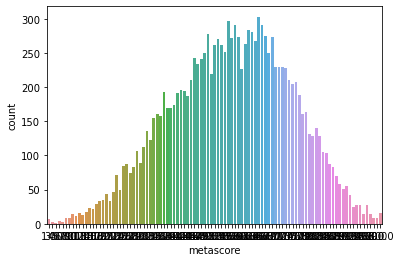

In [27]:
meta = sns.countplot(data=df_mov_nam, x="metascore")

In [28]:
df_mov_nam.reviews_from_users.max()

10472.0

In [29]:
df_mov_nam.reviews_from_users.min()

1.0

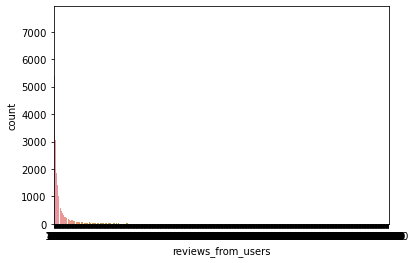

In [30]:
meta = sns.countplot(data=df_mov_nam, x="reviews_from_users")

<AxesSubplot:xlabel='avg_vote', ylabel='reviews_from_users'>

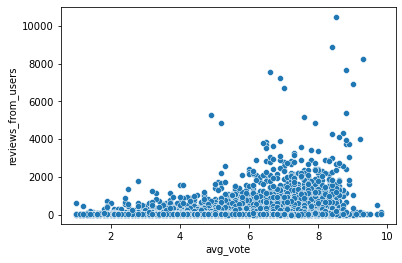

In [31]:
sns.scatterplot(data=df_mov_nam, x="avg_vote", y="reviews_from_users")

In [32]:
df_mov_nam.reviews_from_critics.max()

999.0

In [33]:
df_mov_nam.reviews_from_critics.min()

1.0

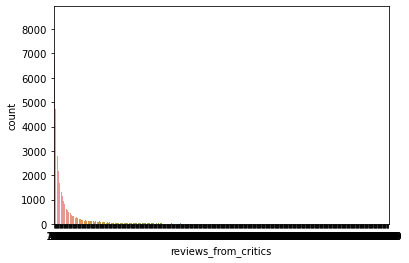

In [34]:
meta = sns.countplot(data=df_mov_nam, x="reviews_from_critics")

<AxesSubplot:xlabel='reviews_from_critics', ylabel='avg_vote'>

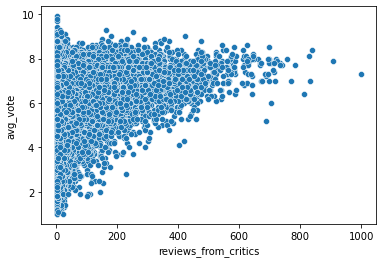

In [35]:
sns.scatterplot(data=df_mov_nam, x="reviews_from_critics", y="avg_vote")

In [36]:
df_mov_nam.isnull().sum()

imdb_title_id               0
original_title              0
year                        0
genre                       0
duration                    0
country                     0
language                    0
director                    0
writer                      0
production_company          0
actors                      0
description                 0
avg_vote                    0
votes                       0
metascore               72550
reviews_from_users       7597
reviews_from_critics    11797
dtype: int64

In [37]:
# Manage the NaNs with the mean of each column
df_mov_nam = df_mov_nam.fillna(value=df_mov_nam["reviews_from_users"].mean())
df_mov_nam = df_mov_nam.fillna(value=df_mov_nam["reviews_from_critics"].mean())

In [38]:
df_mov_nam

,imdb_title_id,original_title,year,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,46.040826,1.000000,2.000000
1,tt0000574,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,46.040826,7.000000,7.000000
2,tt0001892,Den sorte drøm,1911,Drama,53,"Germany, Denmark",0,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,46.040826,5.000000,2.000000
3,tt0002101,Cleopatra,1912,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,46.040826,25.000000,3.000000
4,tt0002130,L'Inferno,1911,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,46.040826,31.000000,14.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,Le lion,2020,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,46.040826,46.040826,4.000000
85851,tt9911196,De Beentjes van Sint-Hildegard,2020,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,46.040826,6.000000,4.000000
85852,tt9911774,Padmavyuhathile Abhimanyu,2019,Drama,130,India,Malayalam,Vineesh Aaradya,"Vineesh Aaradya, Vineesh Aaradya",RMCC Productions,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",0,7.9,265,46.040826,46.040826,46.040826
85853,tt9914286,Sokagin Çocuklari,2019,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",0,6.4,194,46.040826,46.040826,46.040826


In [39]:
# No more NaNs
df_mov_nam.isnull().sum()

imdb_title_id           0
original_title          0
year                    0
genre                   0
duration                0
country                 0
language                0
director                0
writer                  0
production_company      0
actors                  0
description             0
avg_vote                0
votes                   0
metascore               0
reviews_from_users      0
reviews_from_critics    0
dtype: int64